---
author: Naz Salehin
date: 12-01-2024
title: Rivron blastoids cleaning
---

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns

import scvi
import scanpy as sc
import scanpy.external as sce
import scFates as scf
import matplotlib.pyplot as plt

import warnings
from numba.core.errors import NumbaDeprecationWarning
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=FutureWarning)
warnings.simplefilter('ignore', category=UserWarning)

/projects/dan1/data/Brickman/conda/envs/scvi-1.0.0/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/projects/dan1/data/Brickman/conda/envs/scvi-1.0.0/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [2]:
sc.set_figure_params(figsize=(10, 6))

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

## Rivron dataset SRR filtering

In [ ]:
kagawa_samplesheet = pd.read_csv('../data/external/kagawa_samplesheet.csv')

In [ ]:
kagawa_exclude = pd.read_csv('../data/external/kagawa_exclude.txt', header=None)

In [ ]:
kagawa_include = pd.read_csv('../data/external/kagawa_include.txt', header=None)

In [ ]:
new_kagawa_samplesheet = kagawa_samplesheet.loc[kagawa_samplesheet['sample'].isin(kagawa_include[0])].copy()

In [ ]:
new_kagawa_samplesheet.to_csv('../data/external/kagawa_samplesheet_filtered.csv',
                              index=None,
                             quoting=csv.QUOTE_NONNUMERIC)

## fetch-ngs

```
~/Brickman/helper-scripts/nf-core_tower.sh Kagawa_2022 nextflow run brickmanlab/scrnaseq \
    -r feature/smartseq \
    -c /projects/dan1/data/Brickman/projects/proks-salehin-et-al-2023/pipeline/smartseq.human.config \
    --input /scratch/Brickman/pipelines/Kagawa_2022/results/samplesheet/samplesheet_filtered.csv
```

## Rivron dataset preprocessing

In [3]:
adata_rivron = sc.read('../data/external/aligned/human/rivron_2022_reprocessed.h5ad')

In [4]:
adata_rivron

AnnData object with n_obs × n_vars = 2673 × 62754
    obs: 'sample', 'fastq_1', 'fastq_2', 'run_accession', 'experiment_accession', 'sample_accession', 'secondary_sample_accession', 'study_accession', 'secondary_study_accession', 'submission_accession', 'run_alias', 'experiment_alias', 'sample_alias', 'study_alias', 'library_layout', 'library_selection', 'library_source', 'library_strategy', 'instrument_model', 'instrument_platform', 'scientific_name', 'sample_title', 'experiment_title', 'study_title', 'sample_description', 'fastq_md5', 'fastq_bytes', 'fastq_ftp', 'fastq_galaxy', 'fastq_aspera'
    var: 'gene_symbol'

In [5]:
gtf = pd.read_table("../data/external/human/Homo_sapiens.GRCh38.110.gene_length.tsv", index_col=0)
gene_lengths = gtf[['median']].copy()
gene_lengths.columns = ['length']
def normalize_smartseq(adata: sc.AnnData, gene_len: pd.DataFrame) -> sc.AnnData:
    print("SMART-SEQ: Normalization")

    common_genes = adata.var_names.intersection(gene_len.index)
    print(f"SMART-SEQ: Common genes {common_genes.shape[0]}")

    lengths = gene_len.loc[common_genes, "length"].values
    normalized = sc.AnnData(adata[:, common_genes].X, obs=adata.obs, dtype=np.float32)
    normalized.var_names = common_genes
    normalized.X = normalized.X / lengths * np.median(lengths)
    normalized.X = np.rint(normalized.X)

    return normalized

In [6]:
normalize_smartseq(adata_rivron, gene_lengths)

SMART-SEQ: Normalization
SMART-SEQ: Common genes 62663


AnnData object with n_obs × n_vars = 2673 × 62663
    obs: 'sample', 'fastq_1', 'fastq_2', 'run_accession', 'experiment_accession', 'sample_accession', 'secondary_sample_accession', 'study_accession', 'secondary_study_accession', 'submission_accession', 'run_alias', 'experiment_alias', 'sample_alias', 'study_alias', 'library_layout', 'library_selection', 'library_source', 'library_strategy', 'instrument_model', 'instrument_platform', 'scientific_name', 'sample_title', 'experiment_title', 'study_title', 'sample_description', 'fastq_md5', 'fastq_bytes', 'fastq_ftp', 'fastq_galaxy', 'fastq_aspera'

In [7]:
metadata_rivron = adata_rivron.obs

In [8]:
metadata_rivron_clean = metadata_rivron.loc[:,['sample']]

In [9]:
metadata_rivron_clean['sample_title'] = metadata_rivron.sample_title.str.extract(r'^(.*)-', expand = False)

In [10]:
metadata_rivron_clean.sample_title.unique()

array(['primed H9', 'blastoid 96h TROP2 pl', 'naive H9', 'okae bts5',
       'blastoid 24h', 'blastoid 60h TROP2 pl', 'blastoid 60h TROP2 min',
       'blastoid 96h DN', 'blastoid 96h PDGFRa pl',
       'blastoid 60h PDGFRa pl'], dtype=object)

In [11]:
metadata_rivron_clean = metadata_rivron_clean.loc[metadata_rivron_clean.sample_title.isin(['blastoid 96h TROP2 pl', 'naive H9', 'blastoid 24h', 'blastoid 60h TROP2 pl', 'blastoid 60h TROP2 min', 'blastoid 96h DN', 'blastoid 96h PDGFRa pl', 'blastoid 60h PDGFRa pl'])].copy()

In [12]:
metadata_rivron_clean['batch'] = 'Rivron'
metadata_rivron_clean['time'] = metadata_rivron_clean['sample_title']
metadata_rivron_clean['flow'] = metadata_rivron_clean['sample_title']

In [13]:
time_replace_dict = {
    'naive H9': '0h',
    'blastoid 24h': '24h',
    'blastoid 60h TROP2 pl': '60h',
    'blastoid 60h TROP2 min': '60h',
    'blastoid 60h PDGFRa pl': '60h',
    'blastoid 96h DN': '96h',
    'blastoid 96h PDGFRa pl': '96h',
    'blastoid 96h TROP2 pl': '96h'
}

flow_replace_dict = {
    'naive H9': 'naive',
    'blastoid 24h': 'na',
    'blastoid 60h TROP2 pl': 'TROP2+',
    'blastoid 60h TROP2 min': 'TROP2-',
    'blastoid 60h PDGFRa pl': 'PDGFRA+',
    'blastoid 96h DN': 'Double-neg',
    'blastoid 96h PDGFRa pl': 'PDGFRA+',
    'blastoid 96h TROP2 pl': 'TROP2+'
}

metadata_rivron_clean = metadata_rivron_clean.replace({'time': time_replace_dict, 'flow': flow_replace_dict})

In [14]:
adata_rivron = adata_rivron[metadata_rivron_clean.index].copy()

In [15]:
adata_rivron.obs = metadata_rivron_clean

In [16]:
adata_rivron

AnnData object with n_obs × n_vars = 2421 × 62754
    obs: 'sample', 'sample_title', 'batch', 'time', 'flow'
    var: 'gene_symbol'

In [17]:
adata_rivron.var['mt'] = adata_rivron.var.gene_symbol.str.startswith('MT-')



In [18]:
sc.pp.calculate_qc_metrics(adata_rivron, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

<Axes: ylabel='pct_counts_mt'>

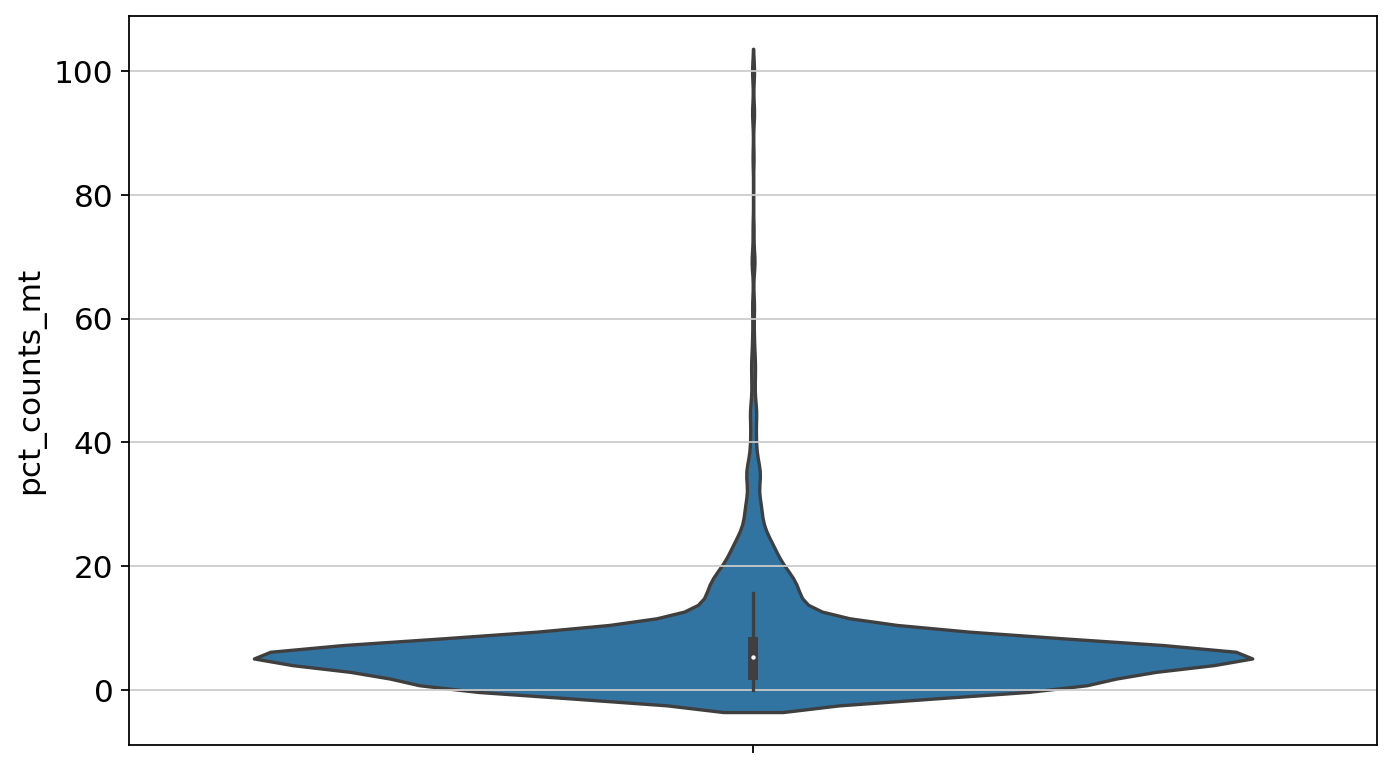

In [19]:
sns.violinplot(y=adata_rivron.obs['pct_counts_mt'], orient='v')

In [20]:
adata_rivron.obs

,sample,sample_title,batch,time,flow,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
SRX11129000_SRX11129000,SRX11129000,blastoid 96h TROP2 pl,Rivron,96h,TROP2+,2897,1081299.0,450085.0,41.624470
SRX11128994_SRX11128994,SRX11128994,blastoid 96h TROP2 pl,Rivron,96h,TROP2+,6437,2058883.0,172783.0,8.392075
SRX11129132_SRX11129132,SRX11129132,naive H9,Rivron,0h,naive,6808,2237799.0,217539.0,9.721114
SRX11129146_SRX11129146,SRX11129146,naive H9,Rivron,0h,naive,7966,1798534.0,115297.0,6.410610
SRX11129013_SRX11129013,SRX11129013,blastoid 96h TROP2 pl,Rivron,96h,TROP2+,6160,1677046.0,143402.0,8.550869
...,...,...,...,...,...,...,...,...,...
SRX11131981_SRX11131981,SRX11131981,blastoid 60h TROP2 min,Rivron,60h,TROP2-,43,4086.0,0.0,0.000000
SRX11131985_SRX11131985,SRX11131985,blastoid 60h TROP2 min,Rivron,60h,TROP2-,5215,837410.0,196307.0,23.442162
SRX11131982_SRX11131982,SRX11131982,blastoid 60h TROP2 min,Rivron,60h,TROP2-,8915,1567157.0,90066.0,5.747095
SRX11131984_SRX11131984,SRX11131984,blastoid 60h TROP2 min,Rivron,60h,TROP2-,5978,1709532.0,0.0,0.000000


<Axes: xlabel='total_counts', ylabel='n_genes_by_counts'>

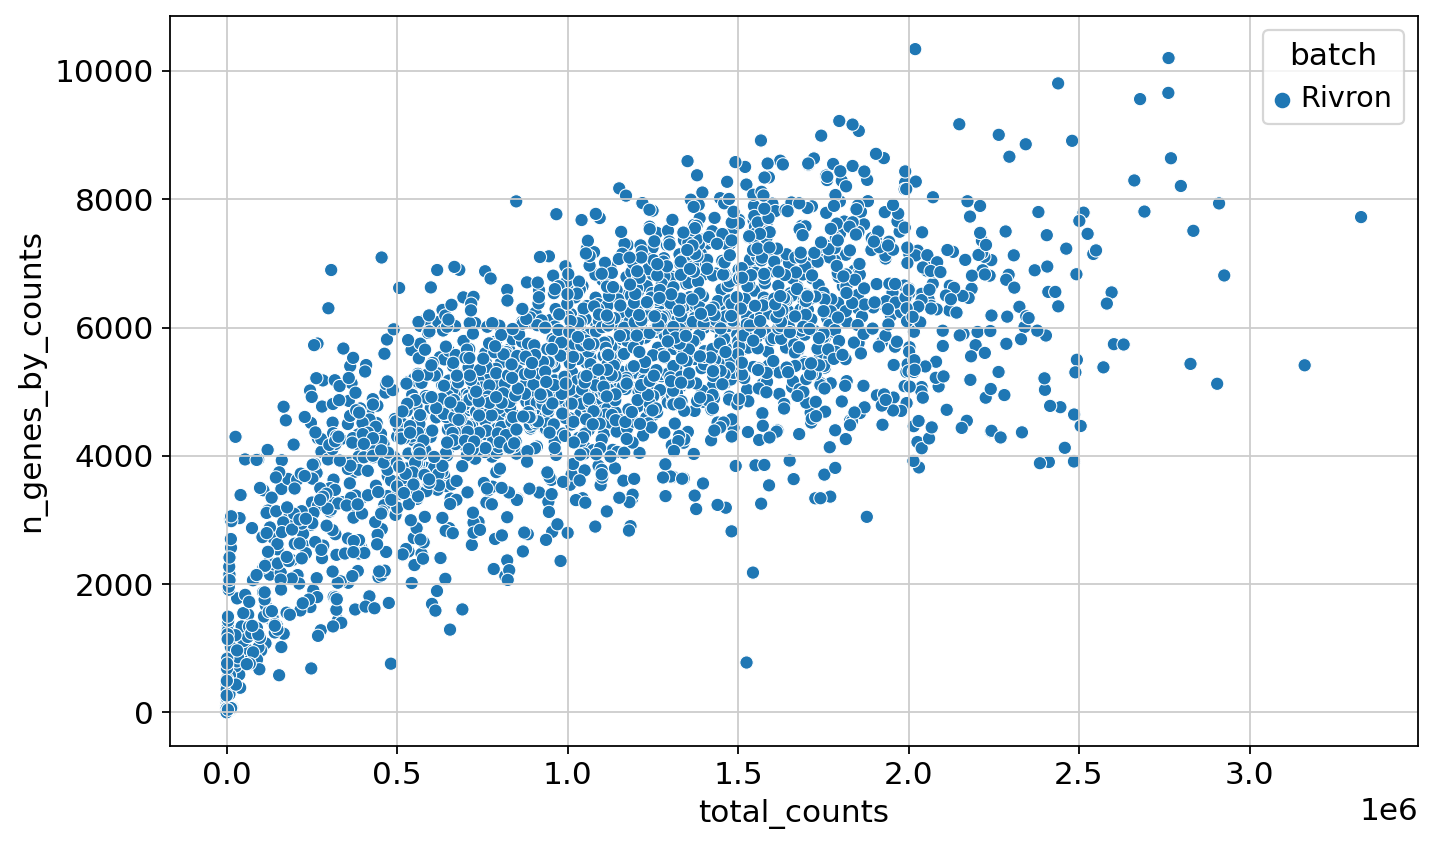

In [21]:
sns.scatterplot(x='total_counts', y='n_genes_by_counts', data=adata_rivron.obs, hue='batch')

In [22]:
adata_rivron = adata_rivron[adata_rivron.obs.pct_counts_mt < 12.5].copy()
sc.pp.filter_cells(adata_rivron, min_counts=2.5e5)
sc.pp.filter_cells(adata_rivron, max_counts=2.5e6)
sc.pp.filter_cells(adata_rivron, min_genes=2_000)
adata_rivron.layers["counts"] = adata_rivron.X.copy()
sc.pp.normalize_total(adata_rivron, target_sum=10_000)
sc.pp.log1p(adata_rivron)
adata_rivron.raw = adata_rivron

In [24]:
# remove mitochondrial genes
adata_rivron = adata_rivron[:, adata_rivron.var[~adata_rivron.var.gene_symbol.str.startswith('MT-')].index].copy()

# remove ribosomal genes
adata_rivron = adata_rivron[:, adata_rivron.var[~adata_rivron.var.gene_symbol.str.startswith(('RPS', 'RPL'))].index].copy()

In [25]:
adata_rivron.write_h5ad('../results/06_human_Rivron.h5ad')

In [3]:
query = sc.read_h5ad('../results/06_human_Rivron.h5ad')
query.obs['experiment'] = 'Rivron'
query

AnnData object with n_obs × n_vars = 1762 × 61002
    obs: 'sample', 'sample_title', 'batch', 'time', 'flow', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'experiment'
    var: 'gene_symbol', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'
    layers: 'counts'

In [11]:
lvae = scvi.model.SCANVI.load("../results/02_human_integration/05_scanvi_ns15/")
#lvae = scvi.model.SCANVI.load("../results/deprecated/human_integration/version_1/scanvi/")

INFO     File ../results/02_human_integration/05_scanvi_ns15/model.pt already downloaded                           


In [12]:
scvi.model.SCVI.prepare_query_anndata(query, lvae)

INFO     Found 92.96666666666667% reference vars in query data.                                                    


In [13]:
lvae_q = scvi.model.SCANVI.load_query_data(query, lvae)

In [14]:
lvae_q.train(
    max_epochs=100,
    plan_kwargs=dict(weight_decay=0.0),
    check_val_every_n_epoch=10,
    early_stopping=True
)

INFO     Training for 100 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 100/100: 100%|█████████████████████| 100/100 [00:20<00:00,  4.97it/s, v_num=1, train_loss_step=4.93e+3, train_loss_epoch=4.65e+3]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|█████████████████████| 100/100 [00:20<00:00,  4.83it/s, v_num=1, train_loss_step=4.93e+3, train_loss_epoch=4.65e+3]


In [15]:
query.obsm["X_scANVI"] = lvae_q.get_latent_representation()
query.obs["predictions"] = lvae_q.predict()
query.obs['entropy'] = 1 - lvae_q.predict(soft=True).max(axis=1)

In [16]:
pd.crosstab(query.obs.predictions, query.obs.flow)

flow,Double-neg,PDGFRA+,TROP2+,TROP2-,na,naive
predictions,,,,,,
8C_3.0,1,0,0,0,0,0
Epiblast_6.0,146,8,52,80,72,49
Epiblast_7.0,120,9,71,65,88,39
Inner Cell Mass,0,1,0,0,0,0
Late epiblast,124,12,42,18,32,42
Morula_4.0,1,0,0,0,0,0
Primitive Endoderm,33,121,33,36,16,6
Trophectoderm_10.0,3,0,4,0,0,0
Trophectoderm_5.0,0,0,1,0,4,0


In [17]:
pd.crosstab(query.obs.predictions, query.obs.time)

time,0h,24h,60h,96h
predictions,,,,
8C_3.0,0,0,0,1
Epiblast_6.0,49,72,120,166
Epiblast_7.0,39,88,111,154
Inner Cell Mass,0,0,1,0
Late epiblast,42,32,38,158
Morula_4.0,0,0,0,1
Primitive Endoderm,6,16,66,157
Trophectoderm_10.0,0,0,0,7
Trophectoderm_5.0,0,4,1,0


In [18]:
sc.pp.highly_variable_genes(
    query,
    flavor="seurat_v3",
    n_top_genes=5_000,
    layer="counts",
    batch_key="batch",
    subset=True,
)
sc.pp.neighbors(query)
sc.tl.umap(query)

         Falling back to preprocessing with `sc.pp.pca` and default params.


2024-01-12 17:05:15.412966: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


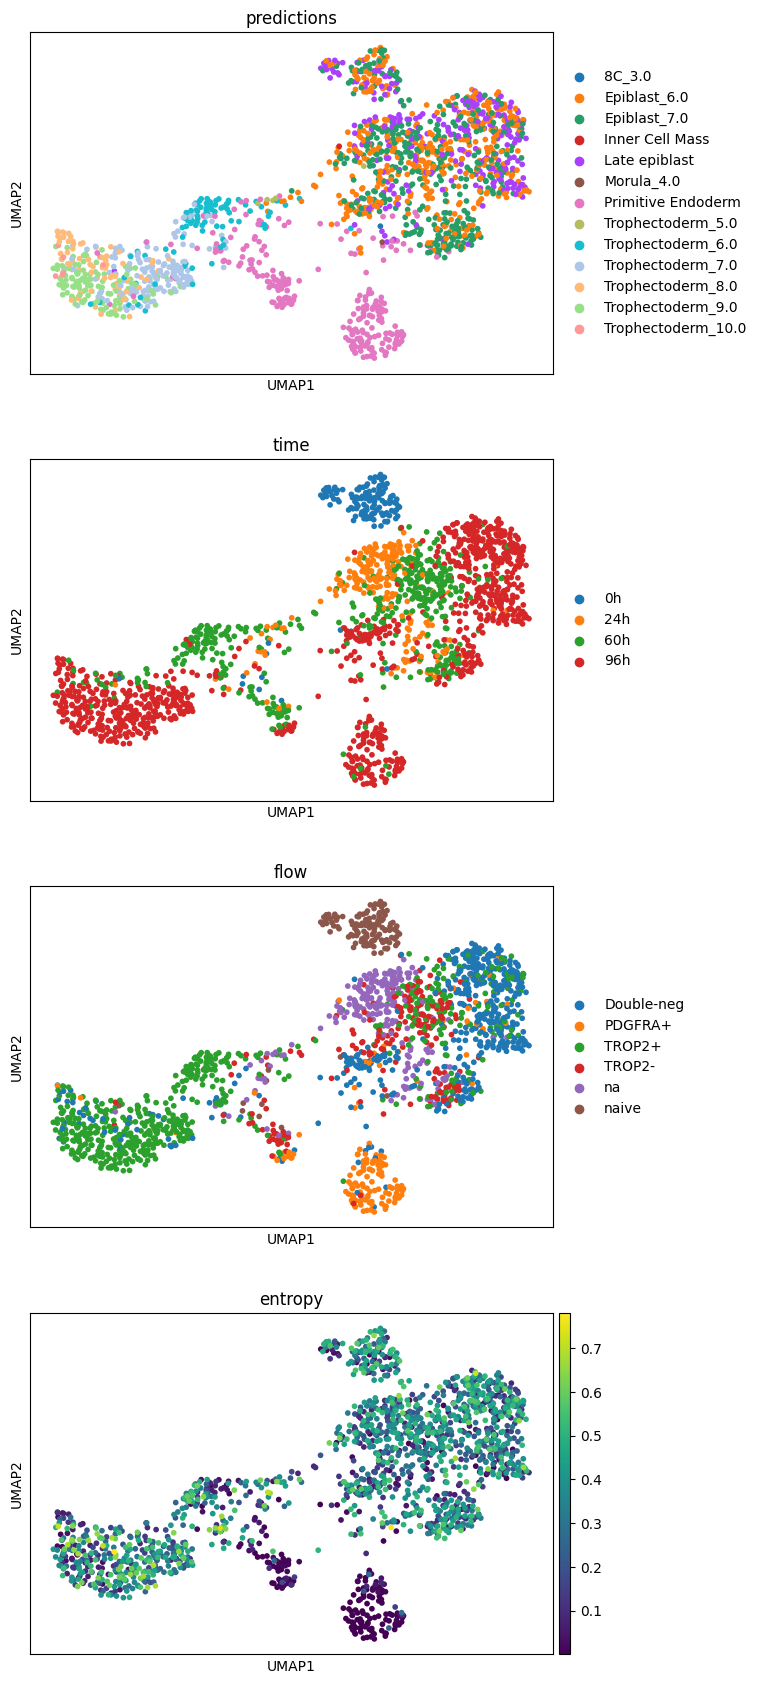

In [19]:
sc.pl.umap(query, color=['predictions','time', 'flow', 'entropy'], ncols=1)